In [1]:
from emulator_utils.pre_process import log_standard, minmax, standard_minmax, unscale
from emulator_utils.read_data import readpowerspec
from emulator_utils.split import random_holdout
from emulator_utils.surrogates import simple_mlp, train_mlp, save_mlp, load_mlp, mcdrop_pred

In [2]:
import matplotlib.pylab as plt
import numpy as np

import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [3]:
mode='train' ## 'test'

In [4]:
# dirIn = '../test/data/sps_ugrizy/'
dirIn = '/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/TrainingData/Data/'

# mags = np.load(dirIn + 'colors.npy')
mags = np.load(dirIn + 'spec.npy')

ebv = np.load(dirIn + 'ebv.npy')
redshift = np.load(dirIn + 'redshift.npy')
sfh = np.load(dirIn + 'sfh.npy')

In [5]:
sps_inputs = np.concatenate((redshift[np.newaxis, :], ebv[np.newaxis, :], sfh.T), axis=0).T

In [6]:
scaled, scaler = standard_minmax(sps_inputs)


In [7]:
scaled_y, scaler_y = log_standard(mags)

In [8]:
param_train, param_test, mag_train, mag_test = random_holdout(scaled, scaled_y, split_fraction = 0.1)

In [9]:
param_train.shape, mag_train.shape

((900, 180), (900, 1212))

In [10]:
# mlp = simple_mlp(input_shape=param_train.shape[1], 
#                  output_shape=mag_train.shape[1], 
#                  hidden_dims=[512, 512, 1024, 1024, 2048, 2048, 1024, 1024])

### Setting Hyper-parameters

In [11]:
# learning_rate = 5e-3
# decay_rate = 0.01
# batch_size = 256
# num_epochs = 300

In [12]:
# if (mode=='train'):
#     mlp, train_history = train_mlp(mlp, 
#                         # param_train, pk_train, param_test, pk_test, 
#                         param_train, mag_train, param_test, mag_test,
#                         learning_rate, decay_rate, num_epochs, batch_size);

#     save_mlp(mlp, '../test/model/spec_mlp')


In [13]:
# if (mode=='train'):
#     plt.figure(2111)
#     plt.plot(train_history.history['loss'], label = 'loss')
#     plt.plot(train_history.history['val_loss'], label = 'val loss')
#     plt.legend()
#     plt.xlabel('epoch')
#     plt.ylabel('loss')
#     plt.show()


In [14]:
mlp = load_mlp('../test/model/spec_mlp')

In [15]:
def prob_color_all(param_in):
    
    '''
    This provides p(colors|redshift, dust, SFH).
    
    '''
    
    sps_in = scaler.transform(param_in)
    mags_pred, _, _ = mcdrop_pred(mlp, sps_in, scaler_y) 
    return mags_pred

In [16]:
# param_train_unscaled = unscale(param_train, scaler)
param_test_unscaled = unscale(param_test, scaler)

pcolor_all = prob_color_all(param_test_unscaled)

(1.0, 100000000.0)

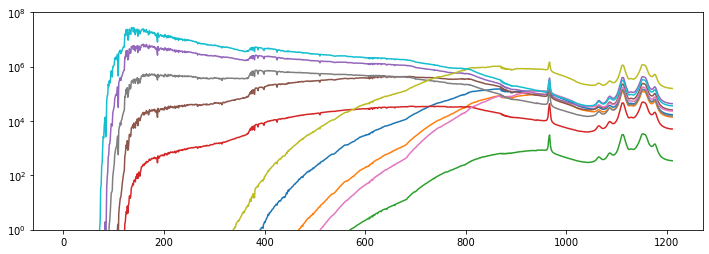

In [17]:
plt.figure(figsize = (12, 4))
plt.plot(unscale(mag_test, scaler_y)[0:10].T, label='truth');
plt.yscale('log')
plt.ylim(1e0, 1e8)

(1.0, 20000000.0)

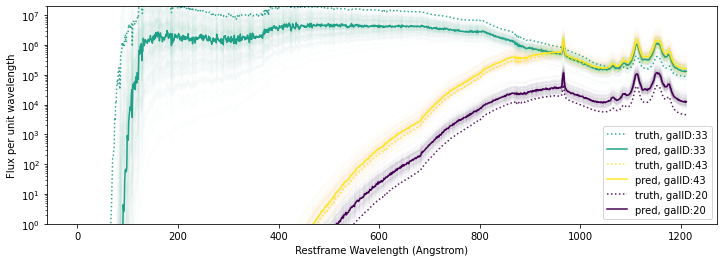

In [18]:
plt.figure(figsize = (12, 4))
# color_arr = ['blue', 'red', 'green']
# indx = -1

galID_arr =  [33, 43, 20]
colorparams = galID_arr
colormap = cm.viridis
normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))


for galID in galID_arr:

    color = colormap(normalize(galID))
    
    plt.plot(unscale(mag_test, scaler_y)[galID], linestyle='dotted', color = color, label='truth, galID:%d'%galID, alpha=0.9)
    
    plt.plot(pcolor_all[:, galID, :].T,  color = color, alpha=0.01)
    plt.plot( np.median(pcolor_all[:, galID, :].T, axis=1),  color = color, alpha=1, label='pred, galID:%d'%galID);


plt.ylabel('Flux per unit wavelength')
plt.xlabel(' Restframe Wavelength (Angstrom) ')

plt.yscale('log')
plt.legend()
plt.ylim(1e0, 2e7)
# plt.xlim(50, 1700)

In [19]:
%timeit unscale(mag_test, scaler_y)[galID]

2.22 ms ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
